In [38]:
# Imports
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import time
import sys
import torch
from sklearn.metrics import f1_score
from nltk import word_tokenize
from nltk.corpus import stopwords
import string, re
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, classification_report)
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from flair.embeddings import FlairEmbeddings,ELMoEmbeddings, WordEmbeddings
from flair.embeddings import DocumentPoolEmbeddings, FastTextEmbeddings ,Sentence, XLNetEmbeddings
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier

In [39]:
def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text

def newsgroups20_dataset_train(directory,train=True, test=False, clean_txt=True):
    """
    Load the 20 Newsgroups dataset.
    """
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    for split_set in splits:
        dataset = fetch_20newsgroups(data_home=directory, subset=split_set, remove=('headers', 'footers', 'quotes'))
        train = []
        for id in range(len(dataset.data)):
            if clean_txt:
                text = clean_text(dataset.data[id])
            else:
                text = ' '.join(word_tokenize(dataset.data[id]))
            label = dataset.target_names[int(dataset.target[id])]

            if text:
                train.append({
                    'text': text,
                    'label': label
                })
    return train
  
def newsgroups20_dataset_test(directory,train=False, test=True, clean_txt=True):
    """
    Load the 20 Newsgroups dataset.
    """
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    for split_set in splits:
        dataset = fetch_20newsgroups(data_home=directory, subset=split_set, remove=('headers', 'footers', 'quotes'))
        test = []
        for id in range(len(dataset.data)):
            if clean_txt:
                text = clean_text(dataset.data[id])
            else:
                text = ' '.join(word_tokenize(dataset.data[id]))
            label = dataset.target_names[int(dataset.target[id])]

            if text:
                test.append({
                    'text': text,
                    'label': label
                })
    return test


# Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    val_data_list = embed(final_val['text'].tolist())
    return train_data_list, test_data_list, val_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    val_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    val_data_list = model.encode(final_val['text'].tolist())
    return train_data_list, test_data_list, val_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    val_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'xlnet':
        print('Starting XLNet Embedding...')
        xlnet_embedding = XLNetEmbeddings('xlnet-large-cased')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[xlnet_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = WordEmbeddings('en')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    print('Validation embedding Started...')
    for text in final_val['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        val_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list, val_data_list

# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test, val):
    #print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    val = ss.transform(val)
    pca = PCA()
    pca = pca.fit(train)
    #print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    test = pca.transform(test)
    val = pca.transform(val)
    return train, test, val

def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    #train_f1 = f1_score(train_true_labels, train_predicted_labels, average='macro')  
    #print('Train F1 Score: ', train_f1)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    #print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy )
    #results_global_list.append(test_f1)
    #results_global_list.append(accuracy)
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    return test_f1, accuracy
    #print(classification_report(test_true_labels, test_predicted_labels))


def data_for_sota():
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    val_data_df['new_label'] = val_data_df['label']
    val_data_df.loc[val_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    val_data_df.loc[val_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 1]
    print(final_train['new_label'].value_counts())
    #val data
    final_val = val_data_df
    print(final_val['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test, final_val


def data_for_autoencoder():
    # Converting the train and test data into dataframe
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    val_data_df['new_label'] = val_data_df['label']
    val_data_df.loc[val_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    val_data_df.loc[val_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 0]
    print(final_train['new_label'].value_counts())
    final_val = val_data_df
    print(final_val['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test, final_val

def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

def ensemble_results(model, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy)
    results_global_list.append(round(test_f1,2))
    results_global_list.append(round(accuracy*100,1))
    #results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    #LABELS = ["known", "unknown"]
    '''plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    #print(classification_report(test_true_labels, test_predicted_labels))
    '''

    
def autoencoder_model(X_Test, Y_Test):
    input_dim = X_train.shape[1]
    print('Input dimension: ',input_dim)
    encoding_dim = 14
    nb_epoch = 100
    batch_size = 32

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", 
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)


    autoencoder.compile(optimizer='adam', 
                        loss='mean_squared_error', 
                        metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath="model_news20.h5",
                                   verbose=0,
                                   save_best_only=True)
    tensorboard = TensorBoard(log_dir='./logs_reuters',
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)

    history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_Test, X_Test),
                        verbose=1,
                        callbacks=[checkpointer, tensorboard]).history
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    autoencoder = load_model('model_news20.h5')
    
    predictions = autoencoder.predict(X_Test)

    mse = np.mean(np.power(X_Test - predictions, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error': mse,
                            'true_class': Y_Test})

    #error_df.describe()
    auto_score_pred = []
    for scor in predictions.tolist():
        auto_score_pred.append(np.mean(scor))
    normalized_auto = [((x-min(auto_score_pred))/(max(auto_score_pred)-min(auto_score_pred))) for x in auto_score_pred]
    print(len(normalized_auto))
    return normalized_auto

[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading data...
Running for Embeddings:  use
Running for News group:  rec.sport.hockey
1    364
Name: new_label, dtype: int64
-1    3776
 1     220
Name: new_label, dtype: int64
-1    6910
 1     389
Name: new_label, dtype: int64
Embeddings Started: 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0107 12:20:45.412622 140048832603520 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0107 12:20:45.732108 140048832603520 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0107 12:20:46.358403 140048832603520 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0107 12:20:47.319534 140048832603520 session_manager.py:493] Done running local_init_op.


Embedding time:  107.74103617668152
----------------- OCSVM Model -----------------


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model:  one Class SVM
Test F1 Score:  0.8807788272589541
Test accuracy: 0.9798602548294287


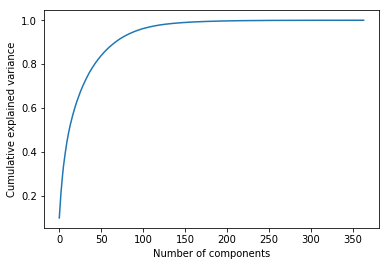

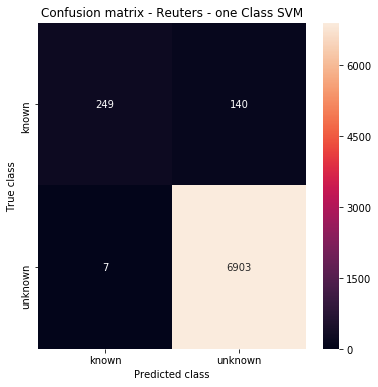

7299
3996
----------------- isolation forest -----------------
Model:  Isolation Forest
Test F1 Score:  0.5909952204439066
Test accuracy: 0.9525962460611043


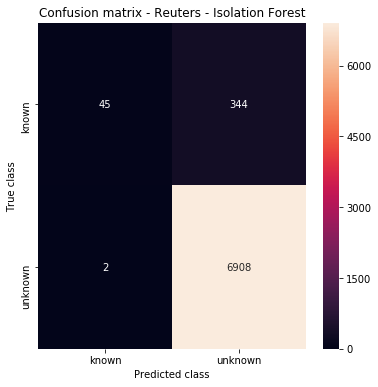

7299
3996
0    364
Name: new_label, dtype: int64
1    3776
0     220
Name: new_label, dtype: int64
1    6910
0     389
Name: new_label, dtype: int64
----------------- Auto Encoder -----------------
Input dimension:  512
Train on 364 samples, validate on 3996 samples
Epoch 1/100
364/364 [==============================] - 0s 992us/step - loss: 0.0035 - accuracy: 0.0275 - val_loss: 0.0040 - val_accuracy: 0.0075
Epoch 2/100
364/364 [==============================] - 0s 713us/step - loss: 0.0029 - accuracy: 0.1566 - val_loss: 0.0038 - val_accuracy: 0.0208
Epoch 3/100
364/364 [==============================] - 0s 625us/step - loss: 0.0026 - accuracy: 0.2610 - val_loss: 0.0037 - val_accuracy: 0.0238
Epoch 4/100
364/364 [==============================] - 0s 797us/step - loss: 0.0024 - accuracy: 0.2857 - val_loss: 0.0036 - val_accuracy: 0.0208
Epoch 5/100
364/364 [==============================] - 0s 816us/step - loss: 0.0023 - accuracy: 0.2857 - val_loss: 0.0035 - val_accuracy: 0.0215
Epoch 6/

364/364 [==============================] - 0s 843us/step - loss: 0.0017 - accuracy: 0.3297 - val_loss: 0.0024 - val_accuracy: 0.0228
Epoch 56/100
364/364 [==============================] - 0s 728us/step - loss: 0.0017 - accuracy: 0.3104 - val_loss: 0.0024 - val_accuracy: 0.0260
Epoch 57/100
364/364 [==============================] - 0s 877us/step - loss: 0.0017 - accuracy: 0.3324 - val_loss: 0.0024 - val_accuracy: 0.0248
Epoch 58/100
364/364 [==============================] - 0s 809us/step - loss: 0.0017 - accuracy: 0.3681 - val_loss: 0.0024 - val_accuracy: 0.0233
Epoch 59/100
364/364 [==============================] - 0s 822us/step - loss: 0.0017 - accuracy: 0.3571 - val_loss: 0.0024 - val_accuracy: 0.0298
Epoch 60/100
364/364 [==============================] - 0s 736us/step - loss: 0.0017 - accuracy: 0.3407 - val_loss: 0.0024 - val_accuracy: 0.0240
Epoch 61/100
364/364 [==============================] - 0s 552us/step - loss: 0.0017 - accuracy: 0.3159 - val_loss: 0.0024 - val_accuracy

Epoch 11/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.2830 - val_loss: 0.0030 - val_accuracy: 0.0232
Epoch 12/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.3214 - val_loss: 0.0029 - val_accuracy: 0.0244
Epoch 13/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.2912 - val_loss: 0.0029 - val_accuracy: 0.0223
Epoch 14/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.2857 - val_loss: 0.0029 - val_accuracy: 0.0238
Epoch 15/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.2747 - val_loss: 0.0029 - val_accuracy: 0.0229
Epoch 16/100
364/364 [==============================] - 1s 1ms/step - loss: 0.0018 - accuracy: 0.2885 - val_loss: 0.0028 - val_accuracy: 0.0225
Epoch 17/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.2857 - val_loss: 0.0028 - val_accuracy:

Epoch 68/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.2857 - val_loss: 0.0025 - val_accuracy: 0.0222
Epoch 69/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.2912 - val_loss: 0.0025 - val_accuracy: 0.0242
Epoch 70/100
364/364 [==============================] - 0s 936us/step - loss: 0.0017 - accuracy: 0.3187 - val_loss: 0.0025 - val_accuracy: 0.0244
Epoch 71/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.2665 - val_loss: 0.0025 - val_accuracy: 0.0264
Epoch 72/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.2940 - val_loss: 0.0025 - val_accuracy: 0.0222
Epoch 73/100
364/364 [==============================] - 0s 993us/step - loss: 0.0017 - accuracy: 0.2527 - val_loss: 0.0025 - val_accuracy: 0.0240
Epoch 74/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.2527 - val_loss: 0.0025 - val_accur

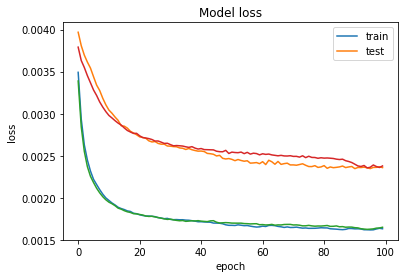

In [40]:
direc = "/opt/notebooks/datasets/news20"
if direc not in nltk.data.path:
    nltk.data.path.append(direc)
nltk.download('stopwords')
nltk.download('punkt')
print('Loading data...')
train_data = newsgroups20_dataset_train(direc)
test_data = newsgroups20_dataset_test(direc)

# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data[:7000], columns = ['text' , 'label'])
val_data_df = pd.DataFrame(train_data[7000:], columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])


group_list = ['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt']
#group_list = ['soc.religion.christian']
embedding_list = ['use']
for embedding in embedding_list:
    print('Running for Embeddings: ', embedding)
    f1_scores = []
    for group in group_list:
        if group == 'rec.sport.hockey':
            start = time.time()
            print('Running for News group: ', group)
            TRAIN_CLASS = group
            results_global_list = []

            #Load data
            final_train, final_test, final_val = data_for_sota()
            print('Embeddings Started: ')
            emb_start = time.time()
            # Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
            if embedding == 'use':
                train_data_list_global, test_data_list_global, val_data_list_global = use_embeddings()
                #train_data_list_isf_global, test_data_list_isf_global = bert_embeddings()
            if embedding == 'bert':    
                train_data_list_global, test_data_list_global, val_data_list_global = bert_embeddings()
            if embedding == 'infersent':
                train_data_list_global, test_data_list_global = infersent_embeddings()
            if embedding == 'glove':
                train_data_list_global, test_data_list_global = other_embeddings('glove')
            if embedding == 'fasttext':
                train_data_list_global, test_data_list_global, val_data_list_global = other_embeddings('fasttext')
            print('Embedding time: ', time.time() - emb_start)

            train_data_list = train_data_list_global
            test_data_list = test_data_list_global
            val_data_list = val_data_list_global
            #PCA
            train_data_list, test_data_list, val_data_list = pca(train_data_list, test_data_list, val_data_list)
            #---------------------------------- Model 1: OCSVM-----------------------------------
            print('----------------- OCSVM Model -----------------')
            svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
            y_pred_train = svm_model.predict(train_data_list)
            y_pred_test = svm_model.predict(test_data_list)
            y_test_scores = svm_model.score_samples(test_data_list)
            y_val_scores = svm_model.score_samples(val_data_list)
            f1, acc = results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test)
            results_global_list.append(round(f1,2))
            results_global_list.append(round(acc*100,1))

            test_score_list = y_test_scores.tolist()
            val_score_list = y_val_scores.tolist()
            normalized_test_svm = [((x-min(test_score_list))/(max(test_score_list)-min(test_score_list))) for x in test_score_list]
            normalized_val_svm = [((x-min(val_score_list))/(max(val_score_list)-min(val_score_list))) for x in val_score_list]
            print(len(normalized_test_svm))
            print(len(normalized_val_svm))

            #---------------------------------- Model 2: Isolation Forest-----------------------------------
            print('----------------- isolation forest -----------------')
            rand_state = np.random.RandomState(42)
            iso_forest = isolationForest(train_data_list, rand_state)
            y_pred_iso_train = iso_forest.predict(train_data_list)
            y_pred_iso_test = iso_forest.predict(test_data_list)
            y_test_scores_isf = iso_forest.score_samples(test_data_list)
            y_val_scores_isf = iso_forest.score_samples(val_data_list)
            f1, acc = results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)
            results_global_list.append(round(f1,2))
            results_global_list.append(round(acc*100,1))

            test_score_list = y_test_scores_isf.tolist()
            val_score_list_isf = y_val_scores_isf.tolist()
            normalized_test_isf = [((x-min(test_score_list))/(max(test_score_list)-min(test_score_list))) for x in test_score_list]
            normalized_val_isf = [((x-min(val_score_list_isf))/(max(val_score_list_isf)-min(val_score_list_isf))) for x in val_score_list_isf]
            print(len(normalized_test_isf))
            print(len(normalized_val_isf))

            '''#----------------------------------Model 3: Local Outlier Factory-----------------------------------
            print('----------------- local outlier factory -----------------')
            svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
            lof = local_outlier_factory(train_data_list, 250)
            y_pred_lof_train = lof.predict(train_data_list)
            y_pred_lof_test = lof.predict(test_data_list)
            f1, acc = results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)
            results_global_list.append(round(f1,2))
            results_global_list.append(round(acc*100,1))'''

            #----------------------------- Model 4: Data processing for AutoEncoder-------------------------------
            # Converting the train and test data into dataframe
            train_data_df = pd.DataFrame(train_data[:7000], columns = ['text' , 'label'])
            val_data_df = pd.DataFrame(train_data[7000:], columns = ['text' , 'label'])
            test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])

            final_train, final_test, final_val = data_for_autoencoder()

            X_train = train_data_list_global
            y_train = final_train['new_label'].tolist()
            X_test = test_data_list_global
            y_test = final_test['new_label'].tolist()
            X_val = val_data_list_global
            y_val = final_val['new_label'].tolist()   

            X_train = np.asarray(X_train)
            X_test = np.asarray(X_test)
            X_val = np.asarray(X_val)

            # ******************************** Auto Encoder Model Bulding ***************************************
            print('----------------- Auto Encoder -----------------')
            auto_val_prediction_scores = autoencoder_model(X_val, y_val)
            concat_array_val = np.array((normalized_val_svm, normalized_val_isf, auto_val_prediction_scores), dtype=float)
            ensemble_array_val = np.append(val_data_list_global, concat_array_val.T, axis=1)
            mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
            mlp.fit(ensemble_array_val, y_val)


            auto_test_prediction_scores = autoencoder_model(X_test, y_test)
            concat_array_test = np.array((normalized_test_svm, normalized_test_isf, auto_test_prediction_scores), dtype=float)
            ensemble_array_test = np.append(test_data_list_global, concat_array_test.T, axis=1)
            ensemble_predictions = mlp.predict(ensemble_array_test)
            text = 'F1 Score for'+ str(group)+ ': '
            print(text , f1_score(y_test,ensemble_predictions, average='macro'))
            print(classification_report(y_test,ensemble_predictions))
            f1_scores.append(f1_score(y_test,ensemble_predictions, average='macro'))
            '''#Load the model for prediction


            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc_auc = auc(fpr, tpr)

            precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

            accuracies = []
            for threshold in th:
                y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
                accuracies.append(balanced_accuracy_score(error_df.true_class, y_pred))
            print("Maximum Test accuracy:", max(accuracies))
            #print(accuracies.index(max(accuracies)))
            print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
            threshold = th[accuracies.index(max(accuracies))]

            groups = error_df.groupby('true_class')

            LABELS = ["known", "unknown"]
            y_pred_autoencoder = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
            conf_matrix = confusion_matrix(error_df.true_class, y_pred_autoencoder,[0,1])
            test_f1 = f1_score(error_df.true_class, y_pred_autoencoder, average='macro')  
            print('Test F1 Score: ', test_f1)
            accuracy = balanced_accuracy_score(error_df.true_class, y_pred_autoencoder)
            print("Test accuracy:", accuracy)
            results_global_list.append(round(test_f1,2))
            results_global_list.append(round(accuracy*100,1))

            # Base individual models end. Ensemble approaches begin from here

            for i in range(len(y_pred_autoencoder)):
                if y_pred_autoencoder[i] == 0:
                    y_pred_autoencoder[i] = 1
                else:
                    y_pred_autoencoder[i] = -1
            #print(y_pred_autoencoder)
            final_train, final_test = data_for_sota()
            print('----------------- Ensemble model -----------------')
            y_pred_test_ensemble = []
            for i in range(len(final_test['new_label'].tolist())):
                arr = [ y_pred_test[i], y_pred_iso_test[i], y_pred_autoencoder[i]]
                y_pred_test_ensemble.append(mostFrequent(arr))

            ensemble_results('Ensemble', final_test['new_label'].tolist(), y_pred_test_ensemble)

            print('f1scores and accuracies: ',results_global_list)'''
    filename = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/results_output_new/exp_ensemble.txt'
    with open(filename, 'w') as f:
        for item in f1_scores:
            f.write("%s\t" % str(item))
    print("total time taken this loop: ", time.time() - start)

In [2]:
dir = "/opt/notebooks/datasets/news20"
if dir not in nltk.data.path:
    nltk.data.path.append(dir)
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text

def newsgroups20_dataset_train(directory=dir,train=True, test=False, clean_txt=True):
    """
    Load the 20 Newsgroups dataset.
    """
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    for split_set in splits:
        dataset = fetch_20newsgroups(data_home=directory, subset=split_set, remove=('headers', 'footers', 'quotes'))
        train = []
        for id in range(len(dataset.data)):
            if clean_txt:
                text = clean_text(dataset.data[id])
            else:
                text = ' '.join(word_tokenize(dataset.data[id]))
            label = dataset.target_names[int(dataset.target[id])]

            if text:
                train.append({
                    'text': text,
                    'label': label
                })
    return train
  
def newsgroups20_dataset_test(directory=dir,train=False, test=True, clean_txt=True):
    """
    Load the 20 Newsgroups dataset.
    """
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    for split_set in splits:
        dataset = fetch_20newsgroups(data_home=directory, subset=split_set, remove=('headers', 'footers', 'quotes'))
        test = []
        for id in range(len(dataset.data)):
            if clean_txt:
                text = clean_text(dataset.data[id])
            else:
                text = ' '.join(word_tokenize(dataset.data[id]))
            label = dataset.target_names[int(dataset.target[id])]

            if text:
                test.append({
                    'text': text,
                    'label': label
                })
    return test

[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

In [3]:
# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    val_data_list = embed(final_val['text'].tolist())
    return train_data_list, test_data_list, val_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    return train_data_list, test_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'xlnet':
        print('Starting XLNet Embedding...')
        xlnet_embedding = XLNetEmbeddings('xlnet-large-cased')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[xlnet_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = WordEmbeddings('en')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list

def elmo_vectors(x):
    elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
    embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))
        
def elmo_embeddings():
    train_data_list = []
    test_data_list = []
    
    elmo_train = [elmo_vectors(final_train['text'].tolist())]
    elmo_test = [elmo_vectors(final_test['text'].tolist())]
    for i in range(len(final_train['text'].tolist())):
        train_data_list.append(elmo_train[0][i])
    for i in range(len(final_test['text'].tolist())):
        test_data_list.append(elmo_test[0][i])
    return train_data_list, test_data_list

def infersent_embeddings():
    train_data_list = []
    test_data_list = []
    sys.path.append('/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master')
    # Load model
    from models import InferSent
    model_version = 1
    MODEL_PATH = "/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    # Keep it on CPU or put it on GPU
    use_cuda = False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/glove.840B.300d-003.txt' if model_version == 1 else '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)
    train_data_list = model.encode(final_train['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(train_data_list)))
    test_data_list = model.encode(final_test['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(test_data_list)))
    return train_data_list, test_data_list

In [4]:

# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test, val):
    print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    pca = PCA()
    pca = pca.fit(train)
    print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    val = pca.transform(val)
    test = pca.transform(test)
    return train, test, val

def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    train_f1 = f1_score(train_true_labels, train_predicted_labels, average='macro')  
    #print('Train F1 Score: ', train_f1)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    #print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy )
    #results_global_list.append(test_f1)
    #results_global_list.append(accuracy)
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    return test_f1, accuracy
    print(classification_report(test_true_labels, test_predicted_labels))

In [5]:
train_data = newsgroups20_dataset_train()
test_data = newsgroups20_dataset_test()

In [6]:
print(len(train_data))
print(len(test_data))

10996
7299


In [7]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data[:7000], columns = ['text' , 'label'])
val_data_df = pd.DataFrame(train_data[7000:], columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])

In [8]:
train_data_df.head()

,text,label
0,wondering anyone could enlighten car saw day d...,rec.autos
1,fair number brave souls upgraded clock oscilla...,comp.sys.mac.hardware
2,well folks mac plus finally gave ghost weekend...,comp.sys.mac.hardware
3,weitek address phone number like get informati...,comp.graphics
4,article cowcb world std com tombaker world std...,sci.space


In [10]:
group_list = ['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt']

TRAIN_CLASS = 'rec.sport.hockey'
results_global_list = []

def data_for_sota():
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    val_data_df['new_label'] = val_data_df['label']
    val_data_df.loc[val_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    val_data_df.loc[val_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 1]
    print(final_train['new_label'].value_counts())
    #val data
    final_val = val_data_df
    print(final_val['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test, final_val

In [11]:
final_train, final_test, final_val = data_for_sota()

1    364
Name: new_label, dtype: int64
-1    3776
 1     220
Name: new_label, dtype: int64
-1    6910
 1     389
Name: new_label, dtype: int64


In [12]:
final_train.head()

,text,label,new_label
20,think mike foligno captain sabres got traded l...,rec.sport.hockey,1
34,funny mention one time hnic cherry pointed van...,rec.sport.hockey,1
56,squid keep tradition alive kinda like fish unh...,rec.sport.hockey,1
87,soderstrom plays philly moulded mask got helme...,rec.sport.hockey,1
112,well see smileys trying figure poster dog word...,rec.sport.hockey,1


In [13]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
train_data_list_global, test_data_list_global, val_data_list_global = use_embeddings()
#train_data_list_global, test_data_list_global = bert_embeddings()
#train_data_list_global, test_data_list_global = infersent_embeddings()
#train_data_list_global, test_data_list_global = elmo_embeddings()
#train_data_list_global, test_data_list_global = other_embeddings('elmo')

Instructions for updating:
Colocations handled automatically by placer.


W0107 12:07:02.695191 140048832603520 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0107 12:07:03.979846 140048832603520 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0107 12:07:04.282517 140048832603520 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0107 12:07:04.998848 140048832603520 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0107 12:07:05.976981 140048832603520 session_manager.py:493] Done running local_init_op.


Principal Component Analysis ...
Explained variance percentage = 1.00


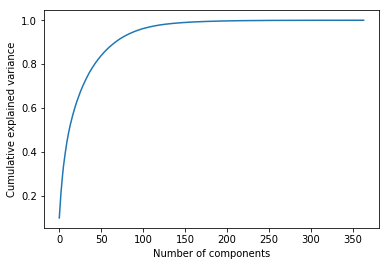

In [14]:
train_data_list = train_data_list_global
test_data_list = test_data_list_global
val_data_list = val_data_list_global
train_data_list, test_data_list, val_data_list = pca(train_data_list, test_data_list, val_data_list)
members = []

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model:  one Class SVM
Test F1 Score:  0.8807788272589541
Test accuracy: 0.9798602548294287


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


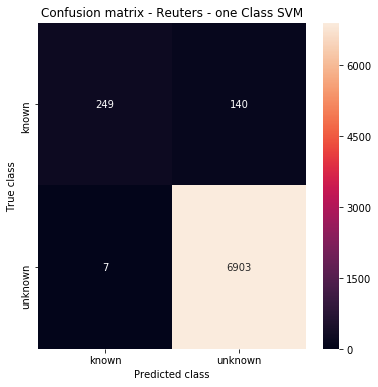

[0.37951797 0.58151379 0.55642135 ... 0.75371917 0.44950903 0.43175149]


In [15]:
svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
y_pred_train = svm_model.predict(train_data_list)
y_pred_test = svm_model.predict(test_data_list)
y_test_scores = svm_model.score_samples(test_data_list)
y_val_scores = svm_model.score_samples(val_data_list)
f1, acc = results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test)
results_global_list.append(round(f1,2))
results_global_list.append(round(acc*100,1))
print(y_test_scores)
#norm_scores = [float(i)/sum(y_test_scores) for i in y_test_scores]
#print(norm_scores)
members.append(svm_model)


In [16]:
score_list = y_test_scores.tolist()
val_score_list = y_val_scores.tolist()
normalized_svm = [((x-min(score_list))/(max(score_list)-min(score_list))) for x in score_list]
normalized_val_svm = [((x-min(val_score_list))/(max(val_score_list)-min(val_score_list))) for x in val_score_list]
print(len(normalized_svm))
print(len(normalized_val_svm))

7299
3996


Model:  Isolation Forest
Test F1 Score:  0.5909952204439066
Test accuracy: 0.9525962460611043


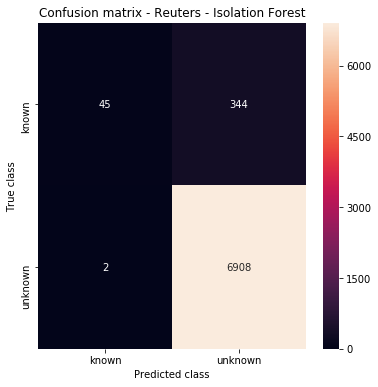

7299
3996


In [17]:
rand_state = np.random.RandomState(42)
iso_forest = isolationForest(train_data_list, rand_state)
y_pred_iso_train = iso_forest.predict(train_data_list)
y_pred_iso_test = iso_forest.predict(test_data_list)
y_test_scores_isf = iso_forest.score_samples(test_data_list)
y_val_scores_isf = iso_forest.score_samples(val_data_list)
f1, acc = results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)
results_global_list.append(round(f1,2))
results_global_list.append(round(acc*100,1))
members.append(iso_forest)

score_list = y_test_scores_isf.tolist()
val_score_list_isf = y_val_scores_isf.tolist()
normalized_isf = [((x-min(score_list))/(max(score_list)-min(score_list))) for x in score_list]
normalized_isf_val = [((x-min(val_score_list_isf))/(max(val_score_list_isf)-min(val_score_list_isf))) for x in val_score_list_isf]
print(len(normalized_isf))
print(len(normalized_isf_val))

Model:  Local Outlier Factory
Test F1 Score:  0.6140071188506723
Test accuracy: 0.8173722427729826


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


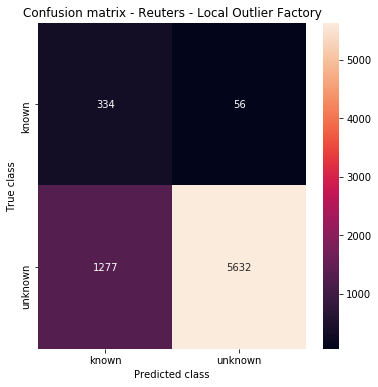

In [17]:
lof = local_outlier_factory(train_data_list, 180)
y_pred_lof_train = lof.predict(train_data_list)
y_pred_lof_test = lof.predict(test_data_list)
f1, acc = results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)
results_global_list.append(round(f1,2))
results_global_list.append(round(acc*100,1))

In [608]:
print(results_global_list)

[0.58, 88.7, 0.54, 95.6, 0.48, 69.0]


In [18]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data[:7000], columns = ['text' , 'label'])
val_data_df = pd.DataFrame(train_data[7000:], columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])

In [19]:
def data_for_autoencoder():
    # Converting the train and test data into dataframe
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    val_data_df['new_label'] = val_data_df['label']
    val_data_df.loc[val_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    val_data_df.loc[val_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 0]
    print(final_train['new_label'].value_counts())
    final_val = val_data_df
    print(final_val['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test, final_val

In [20]:
final_train, final_test, final_val = data_for_autoencoder()

0    364
Name: new_label, dtype: int64
1    3776
0     220
Name: new_label, dtype: int64
1    6910
0     389
Name: new_label, dtype: int64


In [21]:
X_train = train_data_list_global
y_train = final_train['new_label'].tolist()
X_test = test_data_list_global
y_test = final_test['new_label'].tolist()
X_val = val_data_list_global
y_val = final_val['new_label'].tolist()

In [22]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

In [26]:
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 100
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_news20_nn.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs_reuters',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 364 samples, validate on 3996 samples
Epoch 1/100
364/364 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0013
Epoch 2/100
364/364 [==============================] - 0s 701us/step - loss: 0.0029 - accuracy: 0.0055 - val_loss: 0.0036 - val_accuracy: 0.0033
Epoch 3/100
364/364 [==============================] - 0s 737us/step - loss: 0.0026 - accuracy: 0.0055 - val_loss: 0.0036 - val_accuracy: 0.0043
Epoch 4/100
364/364 [==============================] - 0s 627us/step - loss: 0.0024 - accuracy: 0.1236 - val_loss: 0.0035 - val_accuracy: 0.0130
Epoch 5/100
364/364 [==============================] - 0s 550us/step - loss: 0.0023 - accuracy: 0.2610 - val_loss: 0.0034 - val_accuracy: 0.0225
Epoch 6/100
364/364 [==============================] - 0s 552us/step - loss: 0.0022 - accuracy: 0.2775 - val_loss: 0.0033 - val_accuracy: 0.0225
Epoch 7/100
364/364 [==============================] - 0s 522us/step - loss: 0.00

Epoch 57/100
364/364 [==============================] - 0s 705us/step - loss: 0.0017 - accuracy: 0.2912 - val_loss: 0.0025 - val_accuracy: 0.0245
Epoch 58/100
364/364 [==============================] - 0s 748us/step - loss: 0.0017 - accuracy: 0.2418 - val_loss: 0.0025 - val_accuracy: 0.0253
Epoch 59/100
364/364 [==============================] - 0s 696us/step - loss: 0.0017 - accuracy: 0.2802 - val_loss: 0.0025 - val_accuracy: 0.0255
Epoch 60/100
364/364 [==============================] - 0s 630us/step - loss: 0.0017 - accuracy: 0.3049 - val_loss: 0.0025 - val_accuracy: 0.0248
Epoch 61/100
364/364 [==============================] - 0s 686us/step - loss: 0.0017 - accuracy: 0.2720 - val_loss: 0.0024 - val_accuracy: 0.0248
Epoch 62/100
364/364 [==============================] - 0s 602us/step - loss: 0.0017 - accuracy: 0.2802 - val_loss: 0.0024 - val_accuracy: 0.0243
Epoch 63/100
364/364 [==============================] - 0s 612us/step - loss: 0.0017 - accuracy: 0.2692 - val_loss: 0.0024 -

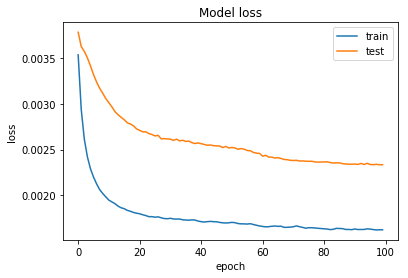

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [28]:
#Load the model for prediction
autoencoder = load_model('model_news20_nn.h5')
predictions = autoencoder.predict(X_test)
members.append(autoencoder)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()


,reconstruction_error,true_class
count,7299.000000,7299.000000
mean,0.001922,0.946705
std,0.000136,0.224636
min,0.001165,0.000000
25%,0.001894,1.000000
50%,0.001947,1.000000
75%,0.001992,1.000000
max,0.002474,1.000000


In [29]:
#Load the model for prediction
autoencoder = load_model('model_news20.h5')
predictions = autoencoder.predict(X_val)
members.append(autoencoder)
mse = np.mean(np.power(X_val - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val})

error_df.describe()


,reconstruction_error,true_class
count,3996.000000,3996.000000
mean,0.001914,0.944945
std,0.000137,0.228116
min,0.001206,0.000000
25%,0.001881,1.000000
50%,0.001933,1.000000
75%,0.001978,1.000000
max,0.002559,1.000000


In [30]:
auto_score_pred = []
for scor in predictions.tolist():
    auto_score_pred.append(np.mean(scor))
normalized_auto = [((x-min(auto_score_pred))/(max(auto_score_pred)-min(auto_score_pred))) for x in auto_score_pred]
print(len(normalized_auto))

3996


In [92]:
print(type(X_test))

<class 'numpy.ndarray'>


In [31]:
concat_arry = np.array((normalized_val_svm, normalized_isf_val, normalized_auto), dtype=float)

In [94]:
print(concat_arry.T)

[[0.62326201 0.78511143 0.16618664]
 [0.66586287 0.38865948 0.40600882]
 [0.68008269 0.38236057 0.16570225]
 ...
 [0.42583738 0.51305628 0.33669437]
 [0.60640097 0.50758731 0.44218644]
 [0.64401465 0.30163866 0.63408817]]


In [32]:
ensemble_array = np.append(val_data_list_global, concat_arry.T, axis=1)
print(ensemble_array.shape)

(3996, 515)


In [33]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(ensemble_array, y_val)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [37]:
ensemble_predictions = mlp.predict(ensemble_array)

auto_test_prediction_scores = autoencoder_model(X_test, y_test)
concat_array_test = np.array((normalized_test_svm, normalized_test_isf, auto_test_prediction_scores), dtype=float)
ensemble_array_test = np.append(test_data_list_global, concat_array_test.T, axis=1)
ensemble_predictions = mlp.predict(ensemble_array_test)
text = 'F1 Score for'+ str(group)+ ': '
print(text , f1_score(y_test,ensemble_predictions, average='macro'))

NameError: name 'autoencoder_model' is not defined

In [35]:
print(classification_report(y_test,ensemble_predictions))

ValueError: Found input variables with inconsistent numbers of samples: [7299, 3996]

In [36]:
print(f1_score(y_val,ensemble_predictions, average='macro') )

1.0


In [55]:
final_train, final_test = data_for_sota()

1    361
Name: new_label, dtype: int64
-1    7055
 1     244
Name: new_label, dtype: int64


In [ ]:
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    # argmax across classes
    result = argmax(summed, axis=1)
    return result

def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)


single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test, final_test['new_label'].tolist())
    # evaluate the i'th model standalone
    #testy_enc = to_categorical(y_test)
    _, single_score = members[i-1].evaluate(X_test, final_test['new_label'].tolist(), verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

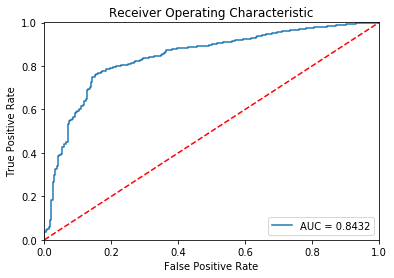

In [617]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [618]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
#plt.plot(recall, precision, 'b', label='Precision-Recall curve')

'''fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].plot(recall, precision, 'b', label='Precision-Recall curve')
axes[0].set_title('Recall vs Precision')
axes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
axes[1].set_title('Precision for different threshold values')
axes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
axes[2].set_title('Recall for different threshold values')
fig.tight_layout()'''

"fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))\naxes[0].plot(recall, precision, 'b', label='Precision-Recall curve')\naxes[0].set_title('Recall vs Precision')\naxes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')\naxes[1].set_title('Precision for different threshold values')\naxes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')\naxes[2].set_title('Recall for different threshold values')\nfig.tight_layout()"

In [619]:
accuracies = []
for threshold in th:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    accuracies.append(balanced_accuracy_score(error_df.true_class, y_pred))
print("Maximum Test accuracy:", max(accuracies))
#print(accuracies.index(max(accuracies)))
print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
threshold = th[accuracies.index(max(accuracies))]
'''fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(accuracies)'''

Maximum Test accuracy: 0.8038988160936901
Threshold for maximal accuracy:  0.0018242791


'fig = plt.figure()\nax = fig.add_subplot(111)\n_ = ax.hist(accuracies)'

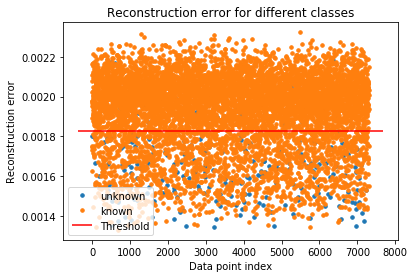

In [620]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "known" if name == 1 else "unknown")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Test F1 Score:  0.5224201231708601
Test accuracy: 0.8038988160936901


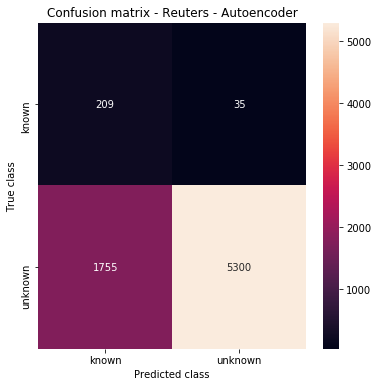

              precision    recall  f1-score   support

           0       0.11      0.86      0.19       244
           1       0.99      0.75      0.86      7055

    accuracy                           0.75      7299
   macro avg       0.55      0.80      0.52      7299
weighted avg       0.96      0.75      0.83      7299



In [621]:
LABELS = ["known", "unknown"]
y_pred_autoencoder = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_autoencoder,[0,1])
test_f1 = f1_score(error_df.true_class, y_pred_autoencoder, average='macro')  
print('Test F1 Score: ', test_f1)
accuracy = balanced_accuracy_score(error_df.true_class, y_pred_autoencoder)
print("Test accuracy:", accuracy)
results_global_list.append(round(test_f1,2))
results_global_list.append(round(accuracy*100,1))
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Reuters - Autoencoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print(classification_report(error_df.true_class, y_pred_autoencoder))

Base individual models end. Ensemble approaches begin from here

In [24]:
for i in range(len(y_pred_autoencoder)):
    if y_pred_autoencoder[i] == 0:
        y_pred_autoencoder[i] = 1
    else:
        y_pred_autoencoder[i] = -1
#print(y_pred_autoencoder)
final_train, final_test = data_for_sota()

NameError: name 'y_pred_autoencoder' is not defined

Model:  Ensemble
Test F1 Score:  0.5776946584837437
Test accuracy: 0.8861487875051377


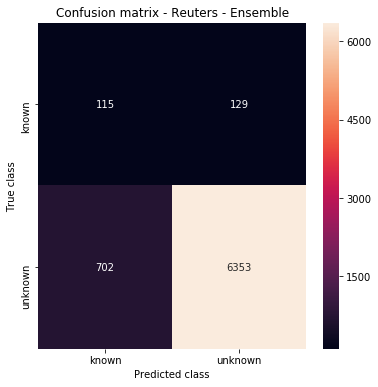

In [623]:
import math as mt
def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

def ensemble_results(model, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy)
    results_global_list.append(round(test_f1,2))
    results_global_list.append(round(accuracy*100,1))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    #print(classification_report(test_true_labels, test_predicted_labels))
    
y_pred_test_ensemble = []



for i in range(len(final_test['new_label'].tolist())):
    arr = [ y_pred_test[i], y_pred_iso_test[i], y_pred_autoencoder[i]]
    y_pred_test_ensemble.append(mostFrequent(arr))

ensemble_results('Ensemble', final_test['new_label'].tolist(), y_pred_test_ensemble)

In [624]:
print(results_global_list)

[0.58, 88.7, 0.54, 95.6, 0.48, 69.0, 0.52, 80.4, 0.58, 88.6]


In [625]:
#!pip install wikipedia2vec
#!pip install -U spacy
print(final_train['text'][27])
final_train.head()

KeyError: 27

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
doc = nlp(final_train['text'][27])

In [ ]:
print(list(doc.ents))

In [ ]:
from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load(MODEL_FILE)
for entity in list(doc.ents):
    vector = wiki2vec.get_entity_vector(entity)
    print(vector)